
# Download the Unsplash dataset (photos) and Create the RAMP Dataset

This notebook is used to download all images from the Unsplash dataset: https://github.com/unsplash/datasets. version Lite (25000 images) 


In [143]:
from pathlib import Path

unsplash_dataset_path = Path("unsplash-research-dataset-lite-latest")

## Load the dataset

The `photos.tsv000` contains metadata about the photos in the dataset, but not the photos themselves. We will use the URLs of the photos to download the actual images.

In [144]:
import pandas as pd

# Read the photos table
photos = pd.read_csv(unsplash_dataset_path / "photos.tsv000", sep='\t', header=0)

# Extract the IDs and the URLs of the photos
photo_urls = photos[['photo_id', 'photo_image_url']].values.tolist()

# Print some statistics
print(f'Photos in the dataset: {len(photo_urls)}')

Photos in the dataset: 25000


The file name of each photo corresponds to its unique ID from Unsplash. We will download the photos in a reduced resolution (640 pixels width), because they are downscaled by CLIP anyway.

CREATE THE "photos" DIRECTORY BEFORE LAUNCHING (must be created in the depository 'unsplash-research-dataset-lite-latest')

In [145]:
import urllib.request

# Path where the photos will be downloaded

photos_donwload_path = unsplash_dataset_path / "photos"

# Function that downloads a single photo
def download_photo(photo):
    # Get the ID of the photo
    photo_id = photo[0]

    # Get the URL of the photo (setting the width to 640 pixels)
    photo_url = photo[1] + "?w=640"

    # Path where the photo will be stored
    photo_path = photos_donwload_path / (photo_id + ".jpg")

    # Only download a photo if it doesn't exist
    if not photo_path.exists():
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except:
            # Catch the exception if the download fails for some reason
            print(f"Cannot download {photo_url}")
            pass

Now the actual download! The download can be parallelized very well, so we will use a thread pool. You may need to tune the `threads_count` parameter to achieve the optimzal performance based on your Internet connection. For me even 128 worked quite well.

In [146]:
from multiprocessing.pool import ThreadPool

# Create the thread pool
threads_count = 16
pool = ThreadPool(threads_count)

# Start the download
pool.map(download_photo, photo_urls)

# Display some statistics
display(f'Photos downloaded: {len(photos)}')

Cannot download https://images.unsplash.com-grass-sun.jpg?w=640
Cannot download https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1668883188879-3a7acd2bec58?w=640
Cannot download https://images.unsplash.com_TheBeach.jpg?w=640
Cannot download https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1675446536649-e0d90add63bb?w=640
Cannot download https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1696839602315-4bf9599635f2?w=640
Cannot download https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1675826725982-e8508781c558?w=640
Cannot download https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1676660359441-c620089f798a?w=640
Cannot download https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1664547606960-008623079291?w=640
Cannot download https://images.unsplash.company?w=640
Cannot download https://images.unsplash.com/unsplash-premium-ph

'Photos downloaded: 25000'

Actually, we have 24978 photos

# Image transformation
Let's analyze one image and how we will compress it

(800, 640, 3)


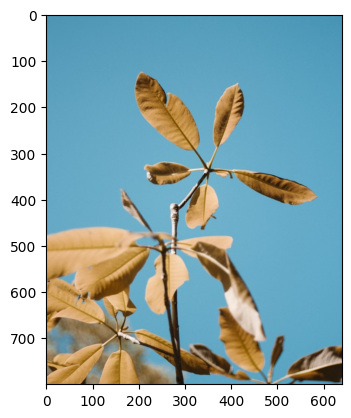

In [148]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(photos_donwload_path / '__1Mu7EZXOM.jpg')
imgplot = plt.imshow(img)
print(img.shape)

In [149]:
def transform_image(img, size_factor=5):
    """
    Reduce resolution of image by a size factor and convert to black and white
    Returns an image of lower size than the original one
    
    Parameters
    ----------
    size_factor: factor resolution change (size_factor = 2, resolution will be divided by 2 in each spatial dimension)
    Returns
    -------
    A black & white image of the spatial dimension of the input image divided by size_factor (no channel)
    """
    from skimage.measure import block_reduce
    import numpy as np
    img_down = block_reduce(img, block_size=(size_factor, size_factor, 1), func=np.max) # reduce resolution
    img_out = np.mean(img_down, axis=2) # convert to Black & White
    
    return img_out

(160, 128)


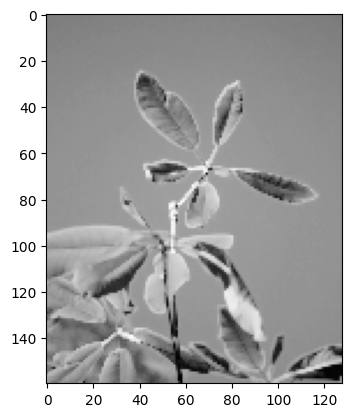

In [150]:
size_factor = 5
img_down = transform_image(img, size_factor=size_factor)
print(img_down.shape)
plt.imshow(img_down, cmap='gray')

Here is a way to come back to the initial image format (full resolution and RGB format, actually we only duplicate onto 3 channels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


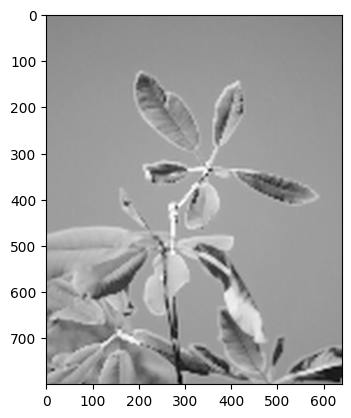

In [151]:
import scipy.ndimage
import numpy as np
img_prep = np.expand_dims(img_down, 2) # add a 3rd dimension for channel
img_prep = np.repeat(img_prep, 3, axis=2) # repeat the same data for each RGB channel

img_reconstructed = scipy.ndimage.zoom(img_prep, (size_factor, size_factor, 1), order=3).astype(int)
# print(img_reconstructed.shape)
plt.imshow(img_reconstructed)

# Dataset creation

Create the "Dataset" depository before launching (in the same depository as this notebook)

In [152]:
import glob
from PIL import Image
from pathlib import Path

photos_path = Path("unsplash-research-dataset-lite-latest") / "photos"
save_path_str = "Dataset/"
counter = 0
pathlist = Path(photos_path).glob('**/*.jpg')
for path in pathlist:
    # print(path)
    img_in = mpimg.imread(path)
    img_out = transform_image(img_in)
    img_in_filename = save_path_str + str(format(counter, '05d')) + "_hi.jpg"
    img_out_filename = save_path_str + str(format(counter, '05d')) + "_lo.jpg"
    mpimg.imsave(img_in_filename, img_in)
    mpimg.imsave(img_out_filename, img_out, cmap='gray')
    # plt.imshow(img)
    counter += 1
    if counter >=25000:
        break

unsplash-research-dataset-lite-latest/photos/ITtjpF5IPdA.jpg
unsplash-research-dataset-lite-latest/photos/5TpBhNBPAE8.jpg
unsplash-research-dataset-lite-latest/photos/2-phOrgQnuY.jpg
unsplash-research-dataset-lite-latest/photos/O_uHS1bru2k.jpg
unsplash-research-dataset-lite-latest/photos/6ppUnVEUHpU.jpg
unsplash-research-dataset-lite-latest/photos/B4XBE_W8sJI.jpg
unsplash-research-dataset-lite-latest/photos/LlELOJhKCdY.jpg
unsplash-research-dataset-lite-latest/photos/T__ouoJ7ojA.jpg
unsplash-research-dataset-lite-latest/photos/UBXoGdfGCnE.jpg
unsplash-research-dataset-lite-latest/photos/tb5lQHsy6IA.jpg
unsplash-research-dataset-lite-latest/photos/bYsTQKjMsys.jpg
unsplash-research-dataset-lite-latest/photos/XoCBgY2zn_M.jpg
unsplash-research-dataset-lite-latest/photos/OxIOi3Q8zWg.jpg
unsplash-research-dataset-lite-latest/photos/E_JDMtW_l0Y.jpg
unsplash-research-dataset-lite-latest/photos/PoK68zebcQ8.jpg
unsplash-research-dataset-lite-latest/photos/kIUT73ix6W4.jpg
unsplash-research-datase